### Задание
Решить задачу перевода с помощью механизма внимания

Возьмите англо-русскую пару фраз (www.manythings.org....org/anki/)<br>
2. Обучите на них seq2seq with attention<br>
    a. На основе скалярного произведения<br>
    b. На основе MLP<br>
Оцените качество

### Практика похожа на предыдущую, но в декодере реализуем механизм внимания.

In [1]:
%matplotlib inline

In [2]:
from io import open
import unicodedata
import string
import re
import random

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

import warnings
warnings.filterwarnings('ignore')

# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = "cpu"

In [3]:
# данные уже загружены, повторная загрузка не требуется
# !wget https://download.pytorch.org/tutorial/data.zip
# !unzip data.zip

In [4]:
# англо-русский текст с предложениями, разделёнными табуляцией
!tail ../../Материалы/rus-eng/eng-rus.txt

We need to uphold laws against discrimination — in hiring, and in housing, and in education, and in the criminal justice system. That is what our Constitution and our highest ideals require.	Нам нужно отстаивать законы против дискриминации при найме на работу, в жилищной сфере, в сфере образования и правоохранительной системе. Этого требуют наша Конституция и высшие идеалы.	CC-BY 2.0 (France) Attribution: tatoeba.org #5762728 (BHO) & #6390439 (odexed)
I've heard that you should never date anyone who is less than half your age plus seven. Tom is now 30 years old and Mary is 17. How many years will Tom need to wait until he can start dating Mary?	Я слышал, что никогда не следует встречаться с кем-то вдвое младше вас плюс семь лет. Тому 30 лет, a Мэри 17. Сколько лет Тому нужно ждать до тех пор, пока он сможет начать встречаться с Мэри?	CC-BY 2.0 (France) Attribution: tatoeba.org #10068197 (CK) & #10644473 (notenoughsun)
I do have one final ask of you as your president, the same thing I a

##### создание класса для предподготовки текста

In [5]:
# подготавливаем текст. его нужно токенизировать. работать будем с грануляцией на уровне слов.
# для этого создаём класс

# создаём токены начала и конца предложения
SOS_token = 0
EOS_token = 1


class Lang:
    def __init__(self, name):
        self.name = name                            # название языка
        self.word2index = {}                        # словарь слово в индекс
        self.word2count = {}                        # словарь слово и количество применений
        self.index2word = {0: "SOS", 1: "EOS"}      # словарь индекс в слово
        self.n_words = 2  # Count SOS and EOS       # текущее количество уникальных слов

    def addSentence(self, sentence): # функция разделяет предложение на токены по пробелам и передаёт слова в функцию addWord
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):                        # функция добавления слова в словарь
        if word not in self.word2index:             # если слова нет в словаре
            self.word2index[word] = self.n_words    # добавляет слово в словарь, слово - ключ, текущее кол-во слов в словаре - значение, т.е.индекс данного слова
            self.word2count[word] = 1               # обновляет количество повторений таких слов в словаре
            self.index2word[self.n_words] = word    # обновляет обратный словарь - индекс данного слова - ключ, само слово - значение
            self.n_words += 1                       # обновляет количество уникальных слов в словаре
        else:                                       # если слово есть в словаре
            self.word2count[word] += 1              # обновляет количество повторений таких слов в словаре

##### вспомогательная функция для удаления лишних символов и перевода символов unicode в обычные символы

In [6]:
# Turn a Unicode string to plain ASCII, thanks to
# http://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):                               # переводит unicode в обычные символы
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

# Lowercase, trim, and remove non-letter characters


def normalizeString(s):
    s = unicodeToAscii(s.lower().strip())   # переводит в ascii, в нижний регистр, обрезает пробелы
    s = re.sub(r"([.!?])", r" \1", s)       # вставляет пробел межды символами ".!?"
    s = re.sub(r"[^a-zа-яё.!?]+", r" ", s)   # меняет все остальные символы на пробел
    return s

##### вспомогательная функция для определения языков перевода и формирования пар предложений

In [7]:
def readLangs(lang1, lang2, reverse=False):                              # принимает названия языков
    print("Reading lines...")

    # Read the file and split into lines
    lines = open('../../Материалы/rus-eng/%s-%s.txt' % (lang1, lang2), encoding='utf-8').\
        read().strip().split('\n')                                       # открывает файл с соответствующим названием, разделяем строки

    # Split every line into pairs and normalize
    pairs = [[normalizeString(s) for s in l.split('\t')[0:2]] for l in lines] # каждую строку разделяет по табуляции и применяет нормализацию
                                                                         # на выходе выдаёт список списков пар предложений
                                                                         # ограничиваем первыми двумя параметрами, третий исключаем
    # Reverse pairs, make Lang instances
    if reverse:                                     # определяет входной и выходной языки
        pairs = [list(reversed(p)) for p in pairs]
        input_lang = Lang(lang2)
        output_lang = Lang(lang1)
    else:
        input_lang = Lang(lang1)
        output_lang = Lang(lang2)

    return input_lang, output_lang, pairs

##### вспомогательная функция для ограничения длины предложения и фильтрации пар

In [8]:
MAX_LENGTH = 10                     # максимальная длина предложения в токенах = 10

eng_prefixes = (                    # английские предложения могут начинаться только с таких токенов
    "i ", 
    "he ", 
    "she ", 
    "you ", 
    "we ", 
    "they ",
    "if",
    "since",
    "at",
    "when"
)


def filterPair(p):                                  # функция фильтрации пар, проверяет длину каждого предложения
    return len(p[0].split(' ')) < MAX_LENGTH and \
        len(p[1].split(' ')) < MAX_LENGTH and \
        p[1].startswith(eng_prefixes)               # переводим с фр. на анг. поэтому проверяем префиксы второго языка - английского


def filterPairs(pairs):                             # функция прогоняет пары через предыдущую функцию
    return [pair for pair in pairs if filterPair(pair)]

##### финальная функция для подготовки данных

In [9]:
def prepareData(lang1, lang2, reverse=False):
    input_lang, output_lang, pairs = readLangs(lang1, lang2, reverse) # запускает функцию readLangs, выдаёт два языка и список списов пар
    print("Read %s sentence pairs" % len(pairs))
    pairs = filterPairs(pairs)                                        # фильтрует пары
    print("Trimmed to %s sentence pairs" % len(pairs))
    print("Counting words...")
    for pair in pairs:                                                # заполняет словари входными и выходными предложениями
        input_lang.addSentence(pair[0])                               
        output_lang.addSentence(pair[1])
    print("Counted words:")
    print(input_lang.name, input_lang.n_words)
    print(output_lang.name, output_lang.n_words)
    return input_lang, output_lang, pairs


input_lang, output_lang, pairs = prepareData('eng', 'rus', True)
print(random.choice(pairs))

Reading lines...
Read 496059 sentence pairs
Trimmed to 162930 sentence pairs
Counting words...
Counted words:
rus 27664
eng 9199
['мы по прежнему движемся .', 'we re still moving .']


##### вспомогательные функции для перевода предложений в тензоры

In [10]:
def indexesFromSentence(lang, sentence):                            # переводит слова в предложении в индексы слов
    return [lang.word2index[word] for word in sentence.split(' ')]


def tensorFromSentence(lang, sentence):                             # переводит индексы слов в тензоры
    indexes = indexesFromSentence(lang, sentence)
    indexes.append(EOS_token)                                       # добавляет к индексам токен конца предложения
    return torch.tensor(indexes, dtype=torch.long, device=device).view(-1, 1) # переводит индексы в тензор нужного размера


def tensorsFromPair(pair):                                          # переводит пары в тензоры
    input_tensor = tensorFromSentence(input_lang, pair[0])
    target_tensor = tensorFromSentence(output_lang, pair[1])
    return (input_tensor, target_tensor)

##### вспомогательные функции для работы со временем, на лекции не разбирали

In [11]:
import time
import math


def asMinutes(s):
    m = math.floor(s / 60)                               # округление вниз
    s -= m * 60                                          # вычитает из секунд минуты
    return '%dm %ds' % (m, s)                            # возвращает время в минутах и секундах


def timeSince(since, percent):                           # рассчитывает время до конца обучения
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

##### вспомогательная функция для отрисовки графика

In [12]:
import matplotlib.pyplot as plt
# plt.switch_backend('agg')
import matplotlib.ticker as ticker
import numpy as np


def showPlot(points):
    plt.figure()
    fig, ax = plt.subplots()
    # this locator puts ticks at regular intervals
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)

##### функция для перевода предложений

In [13]:
def evaluate(encoder, decoder, sentence, max_length=MAX_LENGTH):                       # на вход принимает энкодер, декодер и предложение, ограничение кол-ва токенов
    with torch.no_grad():                                                              # не учитываем градиенты
        input_tensor = tensorFromSentence(input_lang, sentence)                        # переводим входное предложение в тензор
        input_length = input_tensor.size()[0]                                          # считает длину входного предложения
        encoder_hidden = encoder.initHidden()                                          # обнуляет скрытое состояние

        encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)  #
        keys = torch.zeros(max_length, encoder.hidden_size, device=device)
        
        for ei in range(input_length):                                                 # итерируемся по длине входного предложения
            encoder_output, encoder_hidden = encoder(input_tensor[ei], encoder_hidden) # пропускаем каждое слово через энкодер
            encoder_outputs[ei] += encoder_output[0, 0]                                # формируем выходы энкодера, хотя для генерации они не нужны
            

        decoder_input = torch.tensor([[SOS_token]], device=device)                     # создаём тензор для выходного предложения

        decoder_hidden = encoder_hidden                                                # приравниваем скрытое состояние энкодера к декодеру

# ЗДЕСЬ ЕСТЬ ИЗМЕНЕНИЯ ПО СРАВНЕНИЮ СО СТРАНДАРТНОЙ ФУНКЦИЕ ОБУЧЕНИЯ >>>
        decoded_words = []                                                             # список для выходных слов
        decoder_attentions = torch.zeros(max_length, max_length)                       # хранилище для весов внимания, по одной оси входная последовательность, по 
                                                                                       # другой оси выходная последовательность, для каждого эл. вых.
                                                                                       # последовательности находится вектор внимания, который показывает, куда для
                                                                                       # для этого эл. вых. послед. смотрели во входной послед.

        for di in range(max_length):                                                   # итерируемся по максимальной длине
            decoder_output, decoder_hidden, decoder_attention = decoder(decoder_input, # пропускаем вход декодера и скрытое состояние через декодер
                                                    decoder_hidden, encoder_outputs)   # кладём вектор внимания в хранилище внимания
            decoder_attentions[di] = decoder_attention.data
# <<< ЗДЕСЬ ЕСТЬ ИЗМЕНЕНИЯ ПО СРАВНЕНИЮ СО СТРАНДАРТНОЙ ФУНКЦИЕ ОБУЧЕНИЯ

            topv, topi = decoder_output.data.topk(1)                                   # получаем значение и индекс максимальной вероятности
            if topi.item() == EOS_token:                                               # если предложение закончилось
                decoded_words.append('<EOS>')
                break
            else:                                                                      # если предложение не закончилось, то 
                decoded_words.append(output_lang.index2word[topi.item()])              # заполняем список словом, полученным из индекса наиболее высокой вероятности

            decoder_input = topi.squeeze().detach()                                    # кладём в decoder_input индекс последнего сгенерированного токена

        return decoded_words, decoder_attentions[:di + 1]

##### функция случайной генерации

In [14]:
def evaluateRandomly(encoder, decoder, n=5):
    in_sentence = []
    out_sentence = []
    translate_sentence = []
    for i in range(n):
        pair = random.choice(pairs)
        print('>', pair[0])
        print('=', pair[1])
        output_words, attentions = evaluate(encoder, decoder, pair[0])
        output_sentence = ' '.join(output_words)
        print('<', output_sentence)
        print('')
        in_sentence.append(pair[0])
        out_sentence.append(pair[1])
        translate_sentence.append(out_sentence)
    return in_sentence, out_sentence, translate_sentence

##### функция обучения на одном предложении

In [15]:
teacher_forcing_ratio = 0.5 # вероятность использования teacher forcing

def train(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, max_length=MAX_LENGTH):
    encoder_hidden = encoder.initHidden()           # сбрасывает скрытое состояние энкодера

    encoder_optimizer.zero_grad()                   # сбрасывает градиенты
    decoder_optimizer.zero_grad()

    input_length = input_tensor.size(0)             # фиксирует длину входной последовательности
    target_length = target_tensor.size(0)           # фиксирует длину выходной последовательности

    encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device) # это будет использовано на след. занятии для механизма внимания
                                                                                  # пока заполняем нулями
    keys = torch.zeros(max_length, encoder.hidden_size, device=device)

    loss = 0                                        # устанавливаем лосс = 0
    total_words = 0

    for ei in range(input_length):                  # проходимся по длине предложения
        encoder_output, encoder_hidden = encoder(input_tensor[ei], encoder_hidden) # передаём в encoder слово и скрытое состоние для всех слов в предложении
        encoder_outputs[ei] = encoder_output[0, 0]             # кладём выходы модели в соответствующее место выходов по индексу

    decoder_input = torch.tensor([[SOS_token]], device=device) # создаём входную цепочку для decoder, первым кладём туда токен начала предложения

    decoder_hidden = encoder_hidden                            # передаём скрытое представление из энкодера в декодер приравняв одно к другому

    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False    # определяем использование путём случайной вероятности



# ЗДЕСЬ ЕСТЬ ИЗМЕНЕНИЯ ПО СРАВНЕНИЮ СО СТРАНДАРТНОЙ ФУНКЦИЕ ОБУЧЕНИЯ >>>
    if use_teacher_forcing:
        # Teacher forcing: Feed the target as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(    # на вход подаём encoder_outputs, на выходе получаем decoder_attention
                decoder_input, decoder_hidden, encoder_outputs)
            loss += criterion(decoder_output, target_tensor[di])
            decoder_input = target_tensor[di]  # Teacher forcing
            total_words += target_tensor[di].numel()

    else:
        # Without teacher forcing: use its own predictions as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(     # на вход подаём encoder_outputs, на выходе получаем decoder_attention
                decoder_input, decoder_hidden, encoder_outputs)
# <<< ЗДЕСЬ ЕСТЬ ИЗМЕНЕНИЯ ПО СРАВНЕНИЮ СО СТРАНДАРТНОЙ ФУНКЦИЕ ОБУЧЕНИЯ
            
            # для выхода используем жадный алгоритм, который выдаёт top k элементов
            topv, topi = decoder_output.topk(1)      # просим вернуть один элемент с самой большой вероятностью (topv - значение, topi - индекс)
            decoder_input = topi.squeeze().detach()  # убираем из тензора индекса лишние уровни и градиенты

            loss += criterion(decoder_output, target_tensor[di]) # считаем и обновляем значение loss
            if decoder_input.item() == EOS_token:    # если индекс предсказанного токене = EOS, то прекращаем генерацию
                break

    loss.backward()             # считаем градиенты

    encoder_optimizer.step()    # обновляем градиенты в энкодере
    decoder_optimizer.step()    # обновляем градиенты в декодере    

    return loss.item() / target_length # выдаёт лосс нормированный на длину последовательности

##### функция обучения модели, использует функцию обучения на одном предложении выше

In [16]:
def trainIters(encoder, decoder, n_iters, print_every=1000, plot_every=100, learning_rate=0.01):
    # принимает на вход:
    # encoder                   - энкодер
    # decoder                   - декодер
    # n_iters                   - количество итераций
    # print_every=1000          - количекство итерация для печати результатов
    # plot_every=100            - количество итерация для вывода графика
    # learning_rate=0.01        - learning rate

    start = time.time()                                                                 # время начала обучения
    plot_losses = []                                                                    # список лоссов для графика
    print_loss_total = 0  # Reset every print_every                                     # сбрасывает значение счётчика лосс для печати
    plot_loss_total = 0  # Reset every plot_every                                       # сбрасывает значение счётчика лосс для графика

    encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)               # оптимизатор для энкодера
    decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate)               # оптимизатор для декодера
    training_pairs = [tensorsFromPair(random.choice(pairs))                             # формирует случайные пары для обучения
                      for i in range(n_iters)]
    criterion = nn.NLLLoss()                                                            # функция потерь, негативный алгоритм превдоподобия без softmax
                                                                                        # т.к. softmax уже использовали раньше и второй раз этого делать не нужно
    for iter in range(1, n_iters + 1):                                                  # итерируемся по итерациям
        training_pair = training_pairs[iter - 1]                                        # берём тренировочную пару по номеру итерации
        input_tensor = training_pair[0]                                                 # входное предложение
        target_tensor = training_pair[1]                                                # выходное предложение

        loss = train(input_tensor, target_tensor, encoder,                              # получаем лосс путём запуска функции обучения для одного предложения для
                     decoder, encoder_optimizer, decoder_optimizer, criterion)
        print_loss_total += loss
        plot_loss_total += loss

        if iter % print_every == 0:                                                     # если итерация соответствует условиям печати
            print_loss_avg = print_loss_total / print_every                             # печатаем средний лосс
            print_loss_total = 0                                                        # обнуляем счётчик
            print('%s (%d %d%%) %.4f' % (timeSince(start, iter / n_iters),              # печатем результаты
                                         iter, iter / n_iters * 100, print_loss_avg))

        if iter % plot_every == 0:                                                      # если итерация соответствует условиям вывода графика
            plot_loss_avg = plot_loss_total / plot_every                                # считаем средний лосс
            plot_losses.append(plot_loss_avg)                                           # обновляем список лосс для графика
            plot_loss_total = 0                                                         # обнуляем список

    showPlot(plot_losses)                                                               # выводим график

##### пишем функцию для визуализации механизма внимания<br>возвращает перевод предложения<br>отрисовывет механизм внимания

In [17]:
def showAttention(input_sentence, output_words, attentions):
    # Set up figure with colorbar
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(attentions.numpy(), cmap='bone')
    fig.colorbar(cax)

    # Set up axes
    ax.set_xticklabels([''] + input_sentence.split(' ') +
                       ['<EOS>'], rotation=90)
    ax.set_yticklabels([''] + output_words)

    # Show label at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()


def evaluateAndShowAttention(enc, dec, input_sentence):
    output_words, attentions = evaluate(
        enc, dec, input_sentence)
    print('input =', input_sentence)
    print('output =', ' '.join(output_words))
    showAttention(input_sentence, output_words, attentions)

The Encoder
-----------





#### класс энкодекра - обычная RNN с ячейкой GRU
#### энкодер точно такой же, как и в прошлой лекции

In [18]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size):                # на вход принимает размер входа (словаря) и размер скрытого состояния
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size                          # скрытое состояние сохраняется внутри модели

        self.embedding = nn.Embedding(input_size, hidden_size)  # создаётся слой эмбеддингов
        self.gru = nn.GRU(hidden_size, hidden_size)             # рекурренитный слой на основе ячейки GRU, который принимает и выдаёт скрытое состояние

    def forward(self, input, hidden):                           # на вход принимает одно слово и скрытое состояние
        embedded = self.embedding(input).view(1, 1, -1)         # пропускаем слово через эмбеддинги, делаем view для правильного отображения (добавляем 2 пустых слоя)
        output = embedded                                       # приравниваем эмбеддинги к output'ам
        output, hidden = self.gru(output, hidden)               # передаём output и скрытое состояние в рекуррентный слой
        return output, hidden

    def initHidden(self):                                       # сбрасывает скрытое состояние
        return torch.zeros(1, 1, self.hidden_size, device=device)

The Decoder
-----------




##### декодер отличается - в него встраивается механизм внимания (промежуточный), не на скалярном произведении и не на MLP, как были на лекции

### 1. Стандартный декодер, как на лекции

In [19]:
class AttnDecoderRNN_STD(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.1, max_length=MAX_LENGTH):
        super(AttnDecoderRNN_STD, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.dropout_p = dropout_p
        self.max_length = max_length

        self.embedding = nn.Embedding(self.output_size, self.hidden_size)      # слой эмбеддинга
        # новые элементы >>>
        self.attn = nn.Linear(self.hidden_size * 2, self.max_length)           # слой для получения внимания, на вход - двойной размер скрытого состояния, на выходе
                                                                               # коэффициенты похожести
        self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)  # слой для комбинирования результатов
        self.dropout = nn.Dropout(self.dropout_p)                              # слой для регуляризации, dropout
        # новые элементы <<<
        self.gru = nn.GRU(self.hidden_size, self.hidden_size)
        self.out = nn.Linear(self.hidden_size, self.output_size)

    def forward(self, input, hidden, encoder_outputs):                  # на вход принимает одно слово, скрытое состояние и хранилище выходов энкодера
        embedded = self.embedding(input).view(1, 1, -1)                 # эмбеддинги
        embedded = self.dropout(embedded)                               # dropuot

        attn_weights = F.softmax(                                       # начинает работать механизм внимания
            self.attn(torch.cat((embedded[0], hidden[0]), 1)), dim=1)   # принимает сконкатенированные эмбеддинги и скрытое состояние, прогоняет через линейный слой
                                                                        # возвращает все оценки похожести между запросами и значениями; прогоняет через softmax 
                                                                        # на выходе получается вектор коэфф. длиной max_len 
        
        attn_applied = torch.bmm(attn_weights.unsqueeze(0),             # с помощью batchmathmul (позволяет разделить умножение на батчи) умножаем вектор весов на 
                                 encoder_outputs.unsqueeze(0))          # матрицу выхода энкодера и получаем взвешенный вектор выходов энкодера

        output = torch.cat((embedded[0], attn_applied[0]), 1)           # конкатиниуем его с входным эмбеддингом и прогоняем через линейный слой
        output = self.attn_combine(output).unsqueeze(0)                 # получаем выход внимания

        output = F.relu(output)                                         # прогоняем его через relu и отправляем в gru с исходным hidden state
        output, hidden = self.gru(output, hidden)

        output = F.log_softmax(self.out(output[0]), dim=1)              # приводим output к размерности словаря с помощью self.out и дальше прогоняем через
        return output, hidden, attn_weights                             # log_softmax, чтобы получить распределение вероятностей
                                                                        # attn_weights - показывает, куда при переводе конкретного слова смотрелось слово в исходном
                                                                        # предложении  
    def initHidden(self):                                               # сбрасывает скрытое состояние
        return torch.zeros(1, 1, self.hidden_size, device=device)

### 2. DOT product декодер

In [20]:
class AttnDecoderRNN_DOT(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.1, max_length=MAX_LENGTH):
        super(AttnDecoderRNN_DOT, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.dropout_p = dropout_p
        self.max_length = max_length

        self.embedding = nn.Embedding(self.output_size, self.hidden_size)      # слой эмбеддинга
        # новые элементы >>>
        self.attn = nn.Linear(self.hidden_size * 2, self.max_length)           # слой для получения внимания, на вход - двойной размер скрытого состояния, на выходе
                                                                               # коэффициенты похожести
        self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)  # слой для комбинирования результатов
        self.dropout = nn.Dropout(self.dropout_p)                              # слой для регуляризации, dropout
        # новые элементы <<<
        self.gru = nn.GRU(self.hidden_size, self.hidden_size)
        self.out = nn.Linear(self.hidden_size, self.output_size)

    def forward(self, input, hidden, encoder_outputs):                  # на вход принимает одно слово, скрытое состояние и хранилище выходов энкодера
        embedded = self.embedding(input).view(1, 1, -1)                 # эмбеддинги
        embedded = self.dropout(embedded)                               # dropuot

        attn_weights = F.softmax((embedded[0] @ encoder_outputs.T)/(self.max_length**0.5), dim=1)

        # attn_weights = F.softmax(                                       # начинает работать механизм внимания
            # self.attn(torch.cat((embedded[0], hidden[0]), 1)), dim=1)   # принимает сконкатенированные эмбеддинги и скрытое состояние, прогоняет через линейный слой
                                                                        # возвращает все оценки похожести между запросами и значениями; прогоняет через softmax 
                                                                        # на выходе получается вектор коэфф. длиной max_len 
        
        attn_applied = torch.bmm(attn_weights.unsqueeze(0),             # с помощью batchmathmul (позволяет разделить умножение на батчи) умножаем вектор весов на 
                                 encoder_outputs.unsqueeze(0))          # матрицу выхода энкодера и получаем взвешенный вектор выходов энкодера

        output = torch.cat((embedded[0], attn_applied[0]), 1)           # конкатиниуем его с входным эмбеддингом и прогоняем через линейный слой
        output = self.attn_combine(output).unsqueeze(0)                 # получаем выход внимания

        output = F.relu(output)                                         # прогоняем его через relu и отправляем в gru с исходным hidden state
        output, hidden = self.gru(output, hidden)

        output = F.log_softmax(self.out(output[0]), dim=1)              # приводим output к размерности словаря с помощью self.out и дальше прогоняем через
        return output, hidden, attn_weights                             # log_softmax, чтобы получить распределение вероятностей
                                                                        # attn_weights - показывает, куда при переводе конкретного слова смотрелось слово в исходном
                                                                        # предложении  
    def initHidden(self):                                               # сбрасывает скрытое состояние
        return torch.zeros(1, 1, self.hidden_size, device=device)

### 3. MLP декодер

In [21]:
class AttnDecoderRNN_MLP(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.1, max_length=MAX_LENGTH):
        super(AttnDecoderRNN_MLP, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.dropout_p = dropout_p
        self.max_length = max_length

        self.embedding = nn.Embedding(self.output_size, self.hidden_size)      # слой эмбеддинга
        # новые элементы >>>
        self.attn = nn.Linear(self.hidden_size * 2, self.max_length)           # слой для получения внимания, на вход - двойной размер скрытого состояния, на выходе
                                                                               # коэффициенты похожести
        self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)  # слой для комбинирования результатов
        self.dropout = nn.Dropout(self.dropout_p)                              # слой для регуляризации, dropout
        # новые элементы <<<
        self.gru = nn.GRU(self.hidden_size, self.hidden_size)
        self.out = nn.Linear(self.hidden_size, self.output_size)

    def forward(self, input, hidden, encoder_outputs):                  # на вход принимает одно слово, скрытое состояние и хранилище выходов энкодера
        embedded = self.embedding(input).view(1, 1, -1)                 # эмбеддинги
        embedded = self.dropout(embedded)                               # dropuot

        attn_weights = F.softmax(                                       # начинает работать механизм внимания
            self.attn(torch.cat((embedded[0], hidden[0]), 1)), dim=1)   # принимает сконкатенированные эмбеддинги и скрытое состояние, прогоняет через линейный слой
                                                                        # возвращает все оценки похожести между запросами и значениями; прогоняет через softmax 
                                                                        # на выходе получается вектор коэфф. длиной max_len 
        
        attn_applied = torch.bmm(attn_weights.unsqueeze(0),             # с помощью batchmathmul (позволяет разделить умножение на батчи) умножаем вектор весов на 
                                 encoder_outputs.unsqueeze(0))          # матрицу выхода энкодера и получаем взвешенный вектор выходов энкодера

        output = torch.cat((embedded[0], attn_applied[0]), 1)           # конкатиниуем его с входным эмбеддингом и прогоняем через линейный слой
        output = self.attn_combine(output).unsqueeze(0)                 # получаем выход внимания

        output = F.tanh(output)                                         # прогоняем его через relu и отправляем в gru с исходным hidden state
        output, hidden = self.gru(output, hidden)

        output = F.log_softmax(self.out(output[0]), dim=1)              # приводим output к размерности словаря с помощью self.out и дальше прогоняем через
        return output, hidden, attn_weights                             # log_softmax, чтобы получить распределение вероятностей
                                                                        # attn_weights - показывает, куда при переводе конкретного слова смотрелось слово в исходном
                                                                        # предложении  
    def initHidden(self):                                               # сбрасывает скрытое состояние
        return torch.zeros(1, 1, self.hidden_size, device=device)

## Запускаю обучение

#### Общие настройки для обучения

#### В целях экономии времени обучу каждую модель на 50000 итераций.<br>Результат будет не идеальный, но общая идея и общее пониманияе по качеству модели будут понятны.

In [22]:
# настрока для тренировки и основного обучения
n_iters = 50000
print_every = 5000

#### 1. Стандартный декодер, как на лекции

6m 38s (- 59m 43s) (5000 10%) 3.9204
13m 21s (- 53m 25s) (10000 20%) 3.3782
19m 55s (- 46m 28s) (15000 30%) 3.0882
26m 31s (- 39m 47s) (20000 40%) 2.8740
32m 28s (- 32m 28s) (25000 50%) 2.7358
38m 24s (- 25m 36s) (30000 60%) 2.6137
44m 49s (- 19m 12s) (35000 70%) 2.5038
51m 9s (- 12m 47s) (40000 80%) 2.4774
57m 4s (- 6m 20s) (45000 90%) 2.4006
63m 3s (- 0m 0s) (50000 100%) 2.3442


<Figure size 640x480 with 0 Axes>

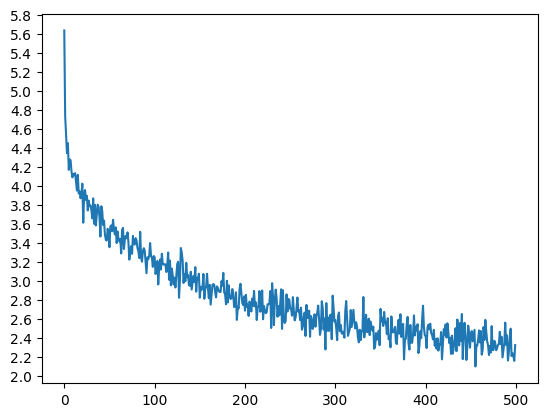

In [23]:
hidden_size = 256                                                   # устанавливаем размер скрытого состояния
encoder1 = EncoderRNN(input_lang.n_words, hidden_size).to(device)   # создаём энкодер
decoder1 = AttnDecoderRNN_STD(hidden_size, output_lang.n_words, dropout_p=0.1).to(device)  # создаём денкодер

trainIters(encoder1, decoder1, n_iters, print_every)

#### Оценка перевода и механизма внимания

In [24]:
in_s, out_s, trans = evaluateRandomly(encoder1, decoder1)

> я долго не осознавала этого .
= i didn t realize it until much later .
< i ve never been to that . . <EOS>

> рад что ты решила приити .
= i m glad you decided to come .
< i m glad you were come . . <EOS>

> я хотел чтобы том приехал в австралию .
= i wanted tom to come to australia .
< i wanted to go to australia to australia . <EOS>

> тебе зеленая стрелка горит .
= you ve got a green arrow .
< you re the at . . . . <EOS>

> мне нужно с тобои потом поговорить .
= i need to talk to you later .
< i need to talk to talk to you . <EOS>



input = я долго не осознавала этого .
output = i m not used to see this . <EOS>


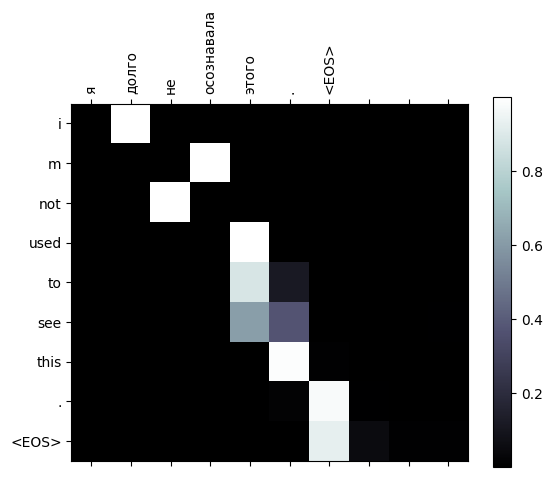

input = рад что ты решила приити .
output = i m glad you were come here . <EOS>


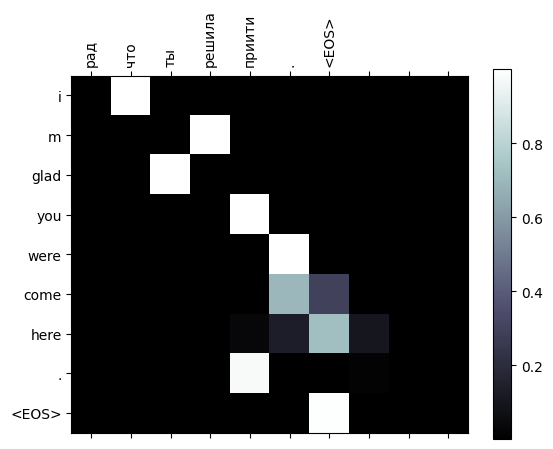

input = я хотел чтобы том приехал в австралию .
output = i wanted to go to australia to australia . <EOS>


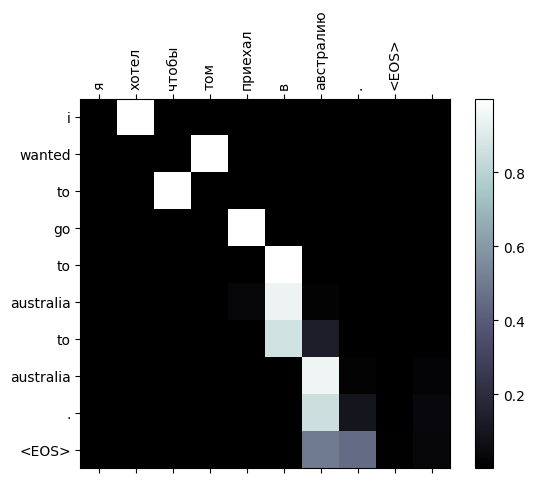

input = тебе зеленая стрелка горит .
output = you re the at . . . . <EOS>


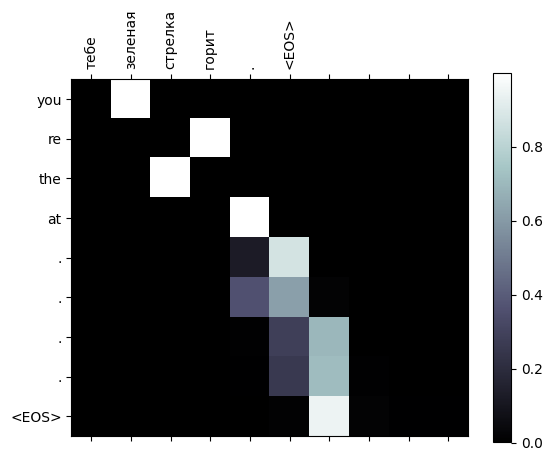

input = мне нужно с тобои потом поговорить .
output = i need to talk to talk to you . <EOS>


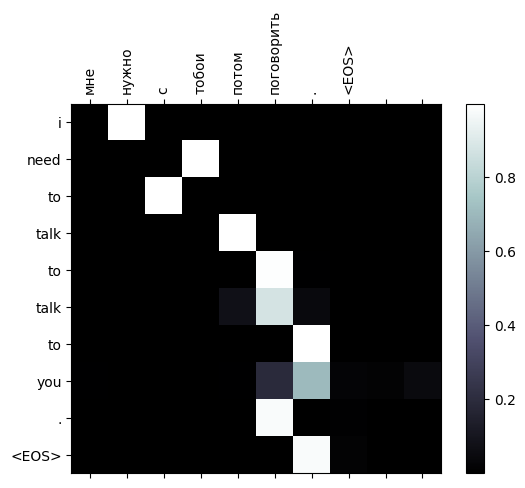

In [25]:
encoder = encoder1
decoder = decoder1
evaluateAndShowAttention(encoder, decoder, in_s[0])
evaluateAndShowAttention(encoder, decoder, in_s[1])
evaluateAndShowAttention(encoder, decoder, in_s[2])
evaluateAndShowAttention(encoder, decoder, in_s[3])
evaluateAndShowAttention(encoder, decoder, in_s[4])

##### Loss - 2.34, переводы достаточно корявые, полагаю, что 50000 эпох недостаточно для нормального обучения, матрицы внимания тоже выглядят достаточно странно.

#### 2. DOT product декодер

5m 55s (- 53m 18s) (5000 10%) 3.8859
11m 50s (- 47m 23s) (10000 20%) 3.3369
17m 37s (- 41m 8s) (15000 30%) 3.1150
23m 27s (- 35m 11s) (20000 40%) 2.8971
29m 9s (- 29m 9s) (25000 50%) 2.7440
34m 55s (- 23m 17s) (30000 60%) 2.6768
40m 55s (- 17m 32s) (35000 70%) 2.5480
46m 47s (- 11m 41s) (40000 80%) 2.4499
52m 38s (- 5m 50s) (45000 90%) 2.4234
58m 35s (- 0m 0s) (50000 100%) 2.3667


<Figure size 640x480 with 0 Axes>

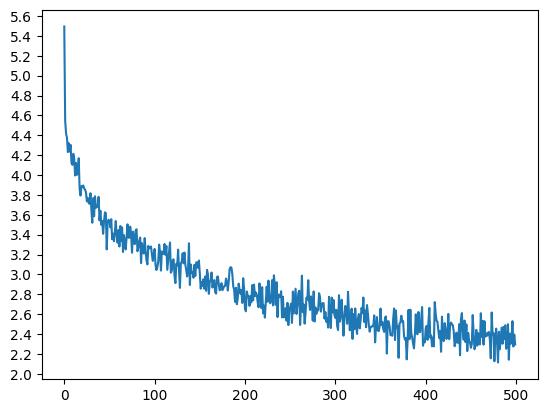

In [26]:
hidden_size = 256                                                   # устанавливаем размер скрытого состояния
encoder2 = EncoderRNN(input_lang.n_words, hidden_size).to(device)   # создаём энкодер
decoder2 = AttnDecoderRNN_DOT(hidden_size, output_lang.n_words, dropout_p=0.1).to(device)  # создаём денкодер

trainIters(encoder2, decoder2, n_iters, print_every)

#### Оценка перевода и механизма внимания

In [27]:
in_s, out_s, trans = evaluateRandomly(encoder2, decoder2)

> нам нужно купить новую стиральную машину .
= we need to buy a new washing machine .
< we need to buy a car car . <EOS>

> я рад что смог помочь .
= i m glad i could help .
< i m glad to help help . <EOS>

> мы не можем позволить себе поражения .
= we cannot permit ourselves to fail .
< we can t afford a of . <EOS>

> она была в агонии .
= she was in agony .
< she was a a . <EOS>

> я думаю что том за мнои наблюдает .
= i think that tom is watching me .
< i think tom was a to me . . <EOS>



input = нам нужно купить новую стиральную машину .
output = we need to buy a car a car . <EOS>


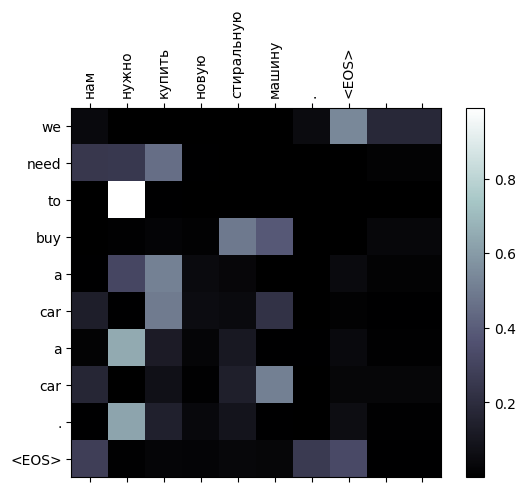

input = я рад что смог помочь .
output = i m glad to help help . <EOS>


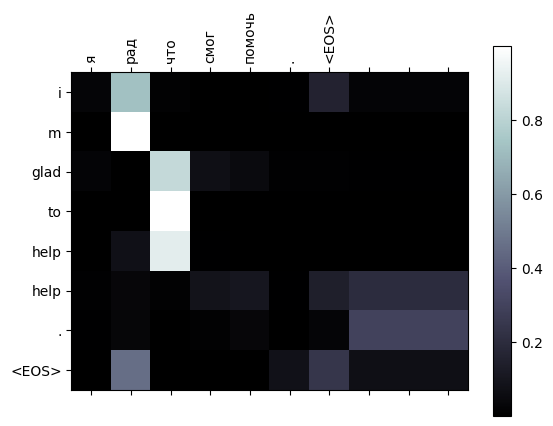

input = мы не можем позволить себе поражения .
output = we can t afford a of . . <EOS>


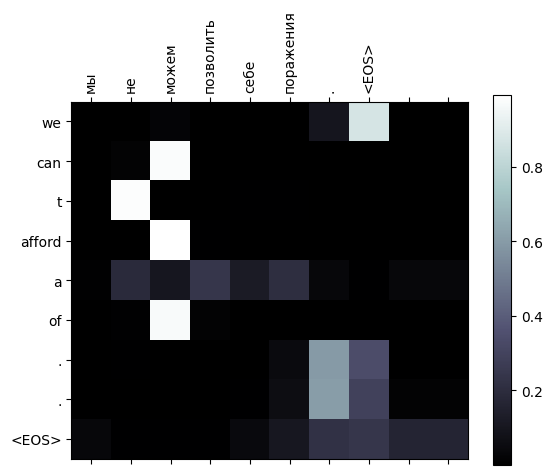

input = она была в агонии .
output = she was a a . <EOS>


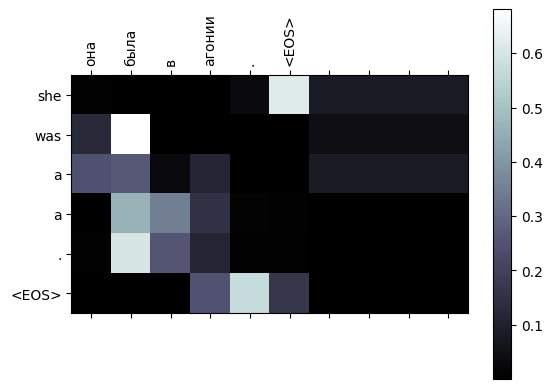

input = я думаю что том за мнои наблюдает .
output = i think tom was a a of . . <EOS>


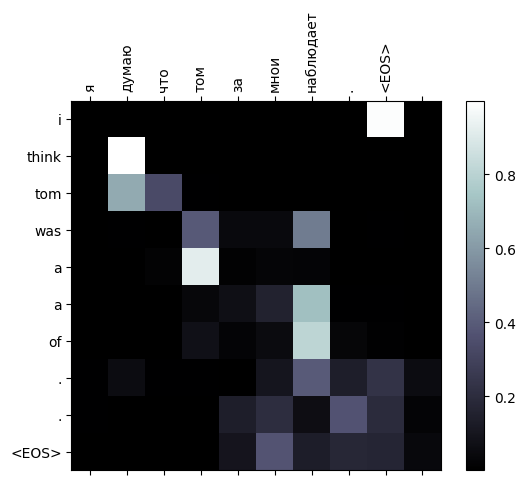

In [28]:
encoder = encoder2
decoder = decoder2
evaluateAndShowAttention(encoder, decoder, in_s[0])
evaluateAndShowAttention(encoder, decoder, in_s[1])
evaluateAndShowAttention(encoder, decoder, in_s[2])
evaluateAndShowAttention(encoder, decoder, in_s[3])
evaluateAndShowAttention(encoder, decoder, in_s[4])

##### Loss - 2.36, переводы также далеки от идеала, а вот матрицы внимания уже более разнообразно смотрят на слова.

### 3. MLP декодер

5m 50s (- 52m 38s) (5000 10%) 3.9233
11m 39s (- 46m 38s) (10000 20%) 3.3245
17m 34s (- 40m 59s) (15000 30%) 3.0843
23m 22s (- 35m 3s) (20000 40%) 2.9192
29m 12s (- 29m 12s) (25000 50%) 2.8067
35m 3s (- 23m 22s) (30000 60%) 2.6736
40m 47s (- 17m 28s) (35000 70%) 2.6072
46m 35s (- 11m 38s) (40000 80%) 2.5387
52m 22s (- 5m 49s) (45000 90%) 2.4870
58m 7s (- 0m 0s) (50000 100%) 2.4570


<Figure size 640x480 with 0 Axes>

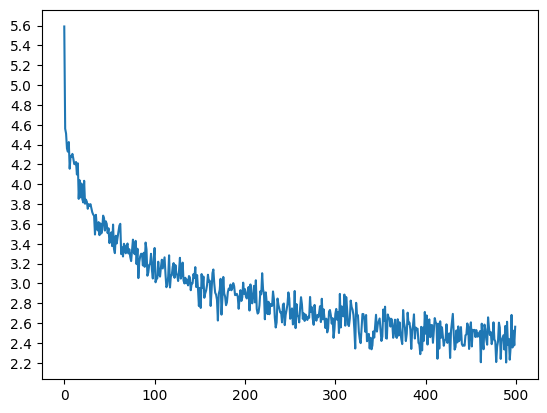

In [29]:
hidden_size = 256                                                   # устанавливаем размер скрытого состояния
encoder3 = EncoderRNN(input_lang.n_words, hidden_size).to(device)   # создаём энкодер
decoder3 = AttnDecoderRNN_MLP(hidden_size, output_lang.n_words, dropout_p=0.1).to(device)  # создаём денкодер

trainIters(encoder3, decoder3, n_iters, print_every)

#### Оценка перевода и механизма внимания

In [30]:
in_s, out_s, trans = evaluateRandomly(encoder3, decoder3)

> мы внесли много улучшении .
= we ve made many improvements .
< we ve a lot . . <EOS>

> мне нужна хорошая работа .
= i need a good job .
< i need a job . <EOS>

> я никогда тебя не любил .
= i ve never loved you .
< i never never you you . <EOS>

> я думал он богатыи .
= i thought he was rich .
< i thought he was be . <EOS>

> он по прежнему пишет стихи .
= he still writes poems .
< he is about the . . <EOS>



input = мы внесли много улучшении .
output = we ve a lot . . <EOS>


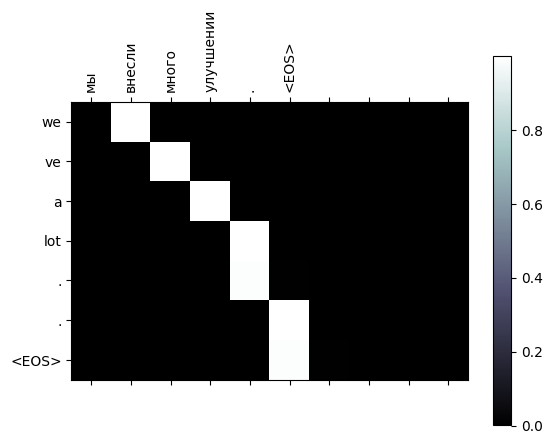

input = мне нужна хорошая работа .
output = i need a job . <EOS>


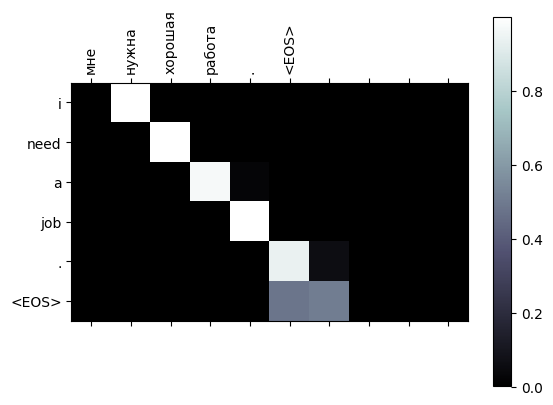

input = я никогда тебя не любил .
output = i never never t you . <EOS>


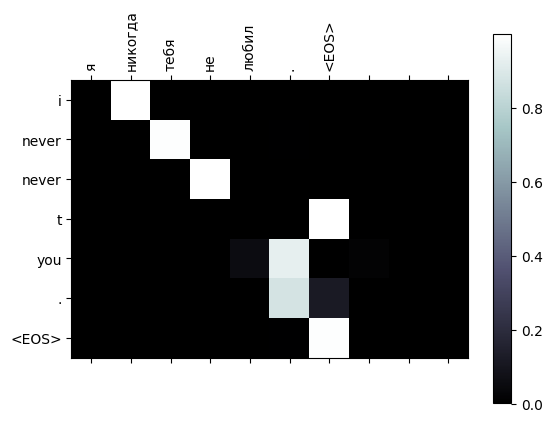

input = я думал он богатыи .
output = i thought he was a . . <EOS>


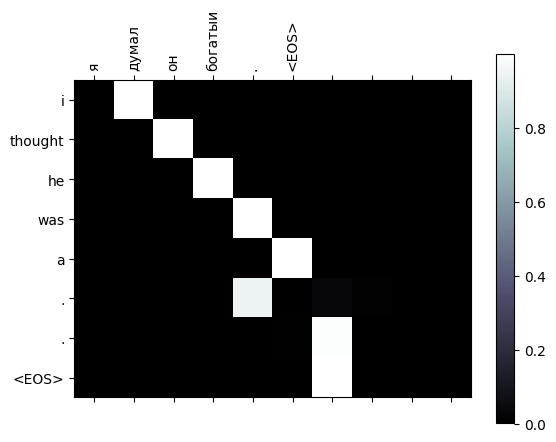

input = он по прежнему пишет стихи .
output = he is just about . <EOS>


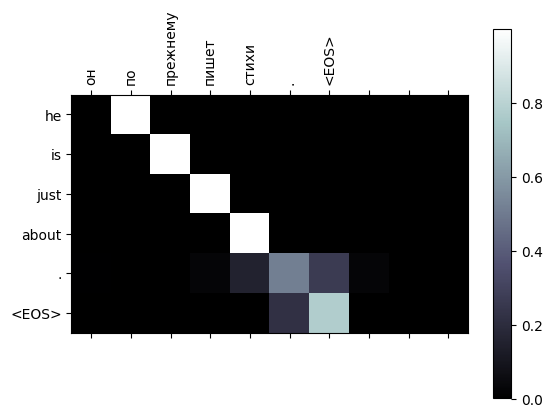

In [31]:
encoder = encoder3
decoder = decoder3
evaluateAndShowAttention(encoder, decoder, in_s[0])
evaluateAndShowAttention(encoder, decoder, in_s[1])
evaluateAndShowAttention(encoder, decoder, in_s[2])
evaluateAndShowAttention(encoder, decoder, in_s[3])
evaluateAndShowAttention(encoder, decoder, in_s[4])

##### Loss - 2.45 - самы высокий, переводы корявые, как и в остальных моделях, матрицы как обычно.

## Вывод:<br>
#### Полагаю, что 50000 эпох недостаточно для обучения, однако на основании результатов выше могу предположить, что неплохое качество может поазать модель со скалярным умножением, при условии обучения на достаточном числе эпох.